In [1]:
import trajectory_manifold.estimation as estimation
import trajectory_manifold.examples as examples
from trajectory_manifold.manifold import SolverParameters

from math import pi

import matplotlib.pyplot as plt
from diffrax import Tsit5, ODETerm, SaveAt, PIDController, diffeqsolve, Kvaerno5, Heun
import jax.numpy as jnp
from jax import random
from jax import grad, jit, vmap
import numpy as onp
import jax.lax as lax
key = random.PRNGKey(1111)

In [2]:
vector_field = examples.lotka_volterra_vector_field(1,2,4,2)

In [5]:
parameters = SolverParameters(relative_tolerance = 1e-2,
                              absolute_tolerance = 1e-2,
                              step_size = 0.2,
                              time_interval = (0,10),
                              solver=Heun(),
                              max_steps=16**6)

In [6]:
key, subkey = random.split(key)
true_init = jnp.abs(random.normal(subkey, shape=(2,)))

In [7]:
term = ODETerm(vector_field)
solver = parameters.solver
observation_times = jnp.arange(parameters.time_interval[0], 
                               parameters.time_interval[1] + parameters.step_size, 
                               step=parameters.step_size)

saveat = SaveAt(ts = observation_times)

stepsize_controller = PIDController(rtol = parameters.relative_tolerance,
                                    atol = parameters.absolute_tolerance)
        
states = diffeqsolve(term,
                     solver,
                     t0 = parameters.time_interval[0],
                     t1 = parameters.time_interval[1],
                     dt0 = 0.1,
                     saveat = saveat,
                     stepsize_controller = stepsize_controller,
                     y0 = true_init).ys


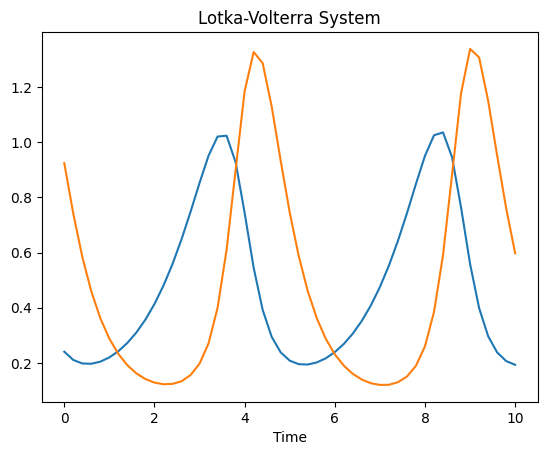

In [8]:
plt.plot(observation_times, states);
plt.xlabel("Time");
plt.title("Lotka-Volterra System");

In [9]:
key, subkey = random.split(key)
noise = random.normal(subkey, shape=states.shape)
observations = states + noise
observation_times = observation_times[:15]
observations = observations[:15]

subsample = 3

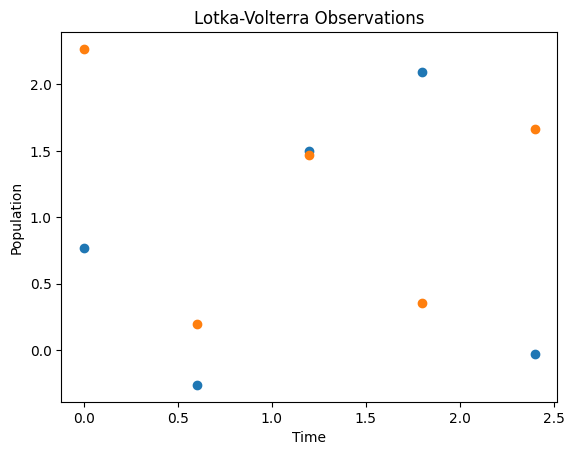

In [10]:
plt.scatter(observation_times[::subsample], observations[::subsample,0]);
plt.scatter(observation_times[::subsample], observations[::subsample,1]);

plt.title("Lotka-Volterra Observations")
plt.xlabel("Time")
plt.ylabel("Population");

In [11]:
def observation_log_likelihood(observation, state):
    partition = jnp.power(2 * pi, -observations.shape[1]/2.0)
    return jnp.log(partition) -1 * jnp.sum(jnp.square(observation - state))/2

In [12]:
def state_log_prior(state):
    partition = jnp.power(2 * pi, -observations.shape[1]/2.0)
    return jnp.log(partition) -1 * jnp.sum(jnp.square(state - true_init))/2

In [13]:
log_likelihood = estimation.trajectory_log_likelihood(vector_field,
                                                       observations[::subsample],
                                                       observation_times[::subsample], 
                                                       observation_log_likelihood,
                                                       parameters)

log_posterior_state = estimation.state_log_posterior(vector_field,
                                                     observations[::subsample],
                                                     observation_times[::subsample], 
                                                     observation_log_likelihood,
                                                     state_log_prior,
                                                     parameters)

log_posterior_trajectory = estimation.trajectory_log_posterior(vector_field,
                                                     observations[::subsample],
                                                     observation_times[::subsample], 
                                                     observation_log_likelihood,
                                                     state_log_prior,
                                                     (0,10),
                                                     parameters)

In [14]:
delta = 0.1
x = y = jnp.arange(0.2, 3.0, delta)
X, Y = jnp.meshgrid(x, y)

In [15]:
samples = jnp.stack([X.flatten(),Y.flatten()])

In [16]:
v_ll = vmap(log_likelihood)
v_ps = vmap(log_posterior_state)

def v_pt(initial_condition):
    out = jnp.zeros(initial_condition.shape[0])
    
    @jit
    def inner(i, out):
        init = initial_condition[i,:]
        out = out.at[i].set(log_posterior_trajectory(init))
        return out
    return lax.fori_loop(0,initial_condition.shape[0], inner, out)

In [ ]:
grid_ll = v_ll(samples.T)
grid_ps = v_ps(samples.T)
grid_pt = v_pt(samples.T)

In [ ]:
grid_ll = jnp.reshape(grid_ll, (x.shape[0], y.shape[0])).T
grid_ps = jnp.reshape(grid_ps, (x.shape[0], y.shape[0])).T
grid_pt = jnp.reshape(grid_pt, (x.shape[0], y.shape[0])).T

In [ ]:
posterior_trajectory = jnp.exp(grid_pt)/jnp.sum(jnp.exp(grid_pt))/(delta**2)
posterior_state = jnp.exp(grid_ps)/jnp.sum(jnp.exp(grid_ps))/(delta**2)

In [ ]:
@jit
def SolveODE(initial_state):
    return diffeqsolve(term,
                     solver,
                     t0 = parameters.time_interval[0],
                     t1 = parameters.time_interval[1],
                     dt0 = 0.1,
                     saveat = saveat,
                     stepsize_controller = stepsize_controller,
                     y0 = initial_state).ys

In [ ]:
solveODE_v = vmap(SolveODE)
solution_set = solveODE_v(samples.T)
solution_set = jnp.reshape(solution_set, (posterior_trajectory.shape[0],posterior_trajectory.shape[1],101,2))

In [ ]:
def square_distance_tensor(solution_set):
    tensor_shape = (solution_set.shape[0],
                    solution_set.shape[1],
                    solution_set.shape[0],
                    solution_set.shape[1])
    out = jnp.zeros(tensor_shape)
    for i in range(solution_set.shape[0]):
        for j in range(solution_set.shape[1]):
            solution = solution_set[i,j,:,:]
            distance_mat = jnp.sum(jnp.square(solution[None, None, :, :] - solution_set), axis=(2,3)) * parameters.step_size
            out = out.at[i,j,:,:].set(distance_mat)
    return out

In [ ]:
def mse_with_distance(density, distance_mat):
    out = jnp.zeros_like(density)
    for i in range(distance_mat.shape[2]):
        for j in range(distance_mat.shape[3]):
            out = out.at[i,j].set(jnp.sum(density[None, None, :, :] * distance_mat[:,:,i,j]))
    return out

In [ ]:
peak_ll = jnp.argmax(grid_ll)
peak_x_ll = x[peak_ll % x.shape[0]]
peak_y_ll = y[peak_ll // x.shape[0]]
ml_est = jnp.stack([peak_x_ll, peak_y_ll])

peak_ps = jnp.argmax(grid_ps)
peak_x_ps = x[peak_ps % x.shape[0]]
peak_y_ps = y[peak_ps // x.shape[0]]
map_state_est = jnp.stack([peak_x_ps, peak_y_ps])

peak_pt = jnp.argmax(grid_pt)
peak_x_pt = x[peak_pt % x.shape[0]]
peak_y_pt = y[peak_pt // x.shape[0]]
map_traj_est = jnp.stack([peak_x_pt, peak_y_pt])

peak_mse = jnp.argmin(mse_mat)
peak_x_mse = x[peak_mse % x.shape[0]]
peak_y_mse = y[peak_mse // x.shape[0]]
mse_traj_est = jnp.stack([peak_x_mse, peak_y_mse])



In [ ]:
distance_mat = square_distance_tensor(solution_set)
mse_mat = mse_with_distance(posterior_trajectory, distance_mat)
mmse_manifold_est_traject = SolveODE(mse_traj_est)

In [ ]:
fig, axs = plt.subplots(2,2)
axs[0,0].contourf(x,y, grid_ll, levels=20)
axs[0,0].scatter([peak_x_ll],[peak_y_ll])
axs[0,0].set(xlabel="Predator Initial Population", ylabel="Prey Initial Population")
axs[0,0].set_title("Initial Condition Likelihood");

axs[0,1].contourf(x,y, grid_ps, levels=20)
axs[0,1].scatter([peak_x_ps],[peak_y_ps])
axs[0,1].set(xlabel="Predator Initial Population", ylabel="Prey Initial Population")
axs[0,1].set_title("Initial Condition Posterior");

axs[1,0].contourf(x,y, mse_mat, levels=20)
axs[1,0].scatter([peak_x_mse],[peak_y_mse])
axs[1,0].set(xlabel="Predator Initial Population", ylabel="Prey Initial Population")
axs[1,0].set_title("Trajectory MSE");

axs[1,1].contourf(x,y, grid_pt, levels=20)
axs[1,1].scatter([peak_x_pt],[peak_y_pt])
axs[1,1].set(xlabel="Predator Initial Population", ylabel="Prey Initial Population")
axs[1,1].set_title("Trajectory Posterior");

fig.set_figheight(6)
fig.tight_layout()

In [ ]:
timesteps = jnp.arange(0,10.1,0.1)
saveat = SaveAt(ts = timesteps)

true_traject = diffeqsolve(term,
                     solver,
                     t0 = 0,
                     t1 = 10,
                     dt0 = 0.1,
                     saveat = saveat,
                     stepsize_controller = stepsize_controller,
                     y0 = true_init).ys

ml_est_traject = diffeqsolve(term,
                     solver,
                     t0 = 0,
                     t1 = 10,
                     dt0 = 0.1,
                     saveat = saveat,
                     stepsize_controller = stepsize_controller,
                     y0 = ml_est).ys

map_est_traject = diffeqsolve(term,
                     solver,
                     t0 = 0,
                     t1 = 10,
                     dt0 = 0.1,
                     saveat = saveat,
                     stepsize_controller = stepsize_controller,
                     y0 = map_state_est).ys

map_traject_est_traject = diffeqsolve(term,
                     solver,
                     t0 = 0,
                     t1 = 10,
                     dt0 = 0.1,
                     saveat = saveat,
                     stepsize_controller = stepsize_controller,
                     y0 = map_traj_est).ys

mmse_ambient_est_traject = jnp.sum(posterior_trajectory[:,:,None, None] * solution_set, axis=(0,1))/100

initial_condition_mmse = jnp.sum(posterior_state[:,:,None] * jnp.reshape(samples.T, (posterior_trajectory.shape[0],posterior_trajectory.shape[1],2)), axis=(0,1))/100
init_mmse_traject = SolveODE(initial_condition_mmse)

In [ ]:
fig, axs = plt.subplots(2,3)

axs[0,0].plot(timesteps, true_traject, linestyle="--")
axs[0,0].set_prop_cycle(None)
axs[0,0].plot(timesteps, ml_est_traject)
axs[0,0].set_title("ML Estimate")
axs[0,0].set(xlabel="Time", ylabel="Population")


axs[0,1].plot(timesteps, true_traject, linestyle="--")
axs[0,1].set_prop_cycle(None)
axs[0,1].plot(timesteps, map_est_traject)
axs[0,1].set_title("MAP State Estimate")
axs[0,1].set(xlabel="Time", ylabel="Population")



axs[1,1].plot(timesteps, true_traject, linestyle="--")
axs[1,1].set_prop_cycle(None)
axs[1,1].plot(timesteps, map_traject_est_traject)
axs[1,1].set_title("MAP Trajectory Estimate")
axs[1,1].set(xlabel="Time", ylabel="Population")



axs[1,0].plot(timesteps, true_traject, linestyle="--")
axs[1,0].set_prop_cycle(None)
axs[1,0].plot(timesteps, mmse_ambient_est_traject)
axs[1,0].set_title("Ambient MMSE Trajectory Estimate")
axs[1,0].set(xlabel="Time", ylabel="Population")

axs[0,2].plot(timesteps, true_traject, linestyle="--")
axs[0,2].set_prop_cycle(None)
axs[0,2].plot(timesteps, init_mmse_traject)
axs[0,2].set_title("MMSE State Estimate")
axs[0,2].set(xlabel="Time", ylabel="Population")


axs[1,2].plot(timesteps, true_traject, linestyle="--")
axs[1,2].set_prop_cycle(None)
axs[1,2].plot(timesteps, mmse_manifold_est_traject)
axs[1,2].set_title("Manifold MMSE Trajectory Estimate")
axs[1,2].set(xlabel="Time", ylabel="Population")

for i in range(2):
    for j in range(3):
        vline = axs[i,j].axvline(x=observation_times[::subsample][-1], linestyle="dotted", color="red")
        axs[i,j].set_xlim(0,10)
        axs[i,j].set_ylim(0,3.5)


fig.set_figwidth(5.5)
fig.set_figheight(3)
fig.tight_layout()

In [242]:
fig.savefig("forecast.pdf", format="pdf", bbox_inches="tight")